# Deep Learning with PyTorch


Author: [Anand Saha](http://teleported.in/)

### 2. Building a simple neural network

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.autograd import Variable

# Custom DataSet
from data import iris

### The Dataset and the challenge

![iris](data/iris.jpg)

The **Iris** flower, image source: [Wikimedia](https://en.wikipedia.org/wiki/Iris_(plant))


| sepal_length_cm | sepal_width_cm | petal_length_cm | petal_width_cm | class           |
|-----------------|----------------|-----------------|----------------|-----------------|
| 5.1             | 3.5            | 1.4             | 0.2            | Iris-setosa     |
| 7.0             | 3.2            | 4.7             | 1.4            | Iris-versicolor |
| 6.3             | 3.3            | 6.0             | 2.5            | Iris-virginica  |


* Total instances: 150 (we have separated 20% into validation set, rest into training set)
* Download: [Data Source](https://archive.ics.uci.edu/ml/datasets/iris)

### Let's do a head on the raw file

In [2]:
!head data/iris.data.txt

sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa
5.0,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa


### Create the Fully Connected Feed Forward Neural Network

**Create the module**

In [3]:
class IrisNet(nn.Module):
    
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

**Print the module**

In [4]:
model = IrisNet(4, 100, 50, 3)
print(model)

IrisNet(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)


### Create the DataLoader

In [5]:
batch_size = 60
iris_data_file = 'data/iris.data.txt'

In [6]:
# Get the datasets
train_ds, test_ds = iris.get_datasets(iris_data_file)

# How many instances have we got?
print('# instances in training set: ', len(train_ds))
print('# instances in testing/validation set: ', len(test_ds))

# Create the dataloaders - for training and validation/testing
# We will be using the term validation and testing data interchangably
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)

# instances in training set:  120
# instances in testing/validation set:  30


### Instantiate the network, the loss function and the optimizer

In [7]:
# Our model
net = IrisNet(4, 100, 50, 3).cuda()

# Out loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, nesterov=True, momentum=0.9, dampening=0)  

### Train it!

Notes: `outputs.data` (in inner loop) winds up being a 2D tensor taking a form like:

```
tensor([[ 10.9044,   4.3022, -13.5821],
        [ 10.1444,   4.0407, -12.6700],
        ...,
        [ -2.7662,   2.7778,  -0.7000]], device='cuda:0')
```

Each number in a row represents the iris's chances of belonging to a particular class, according to the model, with the biggest number being the most likely.

In [8]:
num_epochs = 500

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    
    train_correct = 0
    train_total = 0
    
    for i, (items, classes) in enumerate(train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items.cuda())
        classes = Variable(classes.cuda())
        
        net.train()           # Put the network into training mode
        
        optimizer.zero_grad() # Clear off the gradients from any past operation
        outputs = net(items)  # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        #print("loss is", loss)
        loss.backward()       # Calculate the gradients with help of back propagation
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data
        # (increase train_total by number of items in batch)
        train_total += classes.size(0)    
        # predicted winds up being array of predicted iris classes, each represented by int.
        # In this case, max() reduces 2D tensor down to 1D, finding max value, index for each row
        _, predicted = torch.max(outputs.data, 1)
        # How many predictions were correct in this batch?
        train_correct += (predicted == classes.data).sum()

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, i+1, len(train_ds)//batch_size, loss.item()))

    net.eval()                 # Put the network into evaluation mode
    
    # Book keeping
    # Record the loss (the final one we got down to in current epoch)
    train_loss.append(loss.item())

    # What was our train accuracy?
    train_accuracy.append((100 * train_correct / train_total))
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    test_items = torch.FloatTensor(test_ds.data.values[:, 0:4])
    test_classes = torch.LongTensor(test_ds.data.values[:, 4])

    outputs = net(Variable(test_items.cuda()))
    loss = criterion(outputs, Variable(test_classes.cuda()))
    test_loss.append(loss.item())
    _, predicted = torch.max(outputs.data, 1)
    total = test_classes.size(0)
    correct = (predicted == test_classes.cuda()).sum()
    test_accuracy.append((100 * correct / total))

Epoch 1/500, Iteration 1/2, Loss: 1.1016
Epoch 1/500, Iteration 2/2, Loss: 1.1394
Epoch 2/500, Iteration 1/2, Loss: 1.1060
Epoch 2/500, Iteration 2/2, Loss: 1.1148
Epoch 3/500, Iteration 1/2, Loss: 1.1055
Epoch 3/500, Iteration 2/2, Loss: 1.0892
Epoch 4/500, Iteration 1/2, Loss: 1.0787
Epoch 4/500, Iteration 2/2, Loss: 1.0891
Epoch 5/500, Iteration 1/2, Loss: 1.1009
Epoch 5/500, Iteration 2/2, Loss: 1.0415
Epoch 6/500, Iteration 1/2, Loss: 1.0748
Epoch 6/500, Iteration 2/2, Loss: 1.0372
Epoch 7/500, Iteration 1/2, Loss: 1.0370
Epoch 7/500, Iteration 2/2, Loss: 1.0469
Epoch 8/500, Iteration 1/2, Loss: 1.0445
Epoch 8/500, Iteration 2/2, Loss: 1.0147
Epoch 9/500, Iteration 1/2, Loss: 1.0091
Epoch 9/500, Iteration 2/2, Loss: 1.0263
Epoch 10/500, Iteration 1/2, Loss: 1.0120
Epoch 10/500, Iteration 2/2, Loss: 1.0041
Epoch 11/500, Iteration 1/2, Loss: 1.0212
Epoch 11/500, Iteration 2/2, Loss: 0.9797
Epoch 12/500, Iteration 1/2, Loss: 1.0031
Epoch 12/500, Iteration 2/2, Loss: 0.9818
Epoch 13/5

Epoch 111/500, Iteration 1/2, Loss: 0.3809
Epoch 111/500, Iteration 2/2, Loss: 0.3996
Epoch 112/500, Iteration 1/2, Loss: 0.3900
Epoch 112/500, Iteration 2/2, Loss: 0.3866
Epoch 113/500, Iteration 1/2, Loss: 0.3835
Epoch 113/500, Iteration 2/2, Loss: 0.3886
Epoch 114/500, Iteration 1/2, Loss: 0.3862
Epoch 114/500, Iteration 2/2, Loss: 0.3834
Epoch 115/500, Iteration 1/2, Loss: 0.4180
Epoch 115/500, Iteration 2/2, Loss: 0.3464
Epoch 116/500, Iteration 1/2, Loss: 0.4221
Epoch 116/500, Iteration 2/2, Loss: 0.3380
Epoch 117/500, Iteration 1/2, Loss: 0.3794
Epoch 117/500, Iteration 2/2, Loss: 0.3766
Epoch 118/500, Iteration 1/2, Loss: 0.3845
Epoch 118/500, Iteration 2/2, Loss: 0.3671
Epoch 119/500, Iteration 1/2, Loss: 0.3581
Epoch 119/500, Iteration 2/2, Loss: 0.3919
Epoch 120/500, Iteration 1/2, Loss: 0.3748
Epoch 120/500, Iteration 2/2, Loss: 0.3686
Epoch 121/500, Iteration 1/2, Loss: 0.3970
Epoch 121/500, Iteration 2/2, Loss: 0.3428
Epoch 122/500, Iteration 1/2, Loss: 0.3887
Epoch 122/5

Epoch 220/500, Iteration 2/2, Loss: 0.2787
Epoch 221/500, Iteration 1/2, Loss: 0.2378
Epoch 221/500, Iteration 2/2, Loss: 0.2031
Epoch 222/500, Iteration 1/2, Loss: 0.2194
Epoch 222/500, Iteration 2/2, Loss: 0.2211
Epoch 223/500, Iteration 1/2, Loss: 0.2387
Epoch 223/500, Iteration 2/2, Loss: 0.1981
Epoch 224/500, Iteration 1/2, Loss: 0.1869
Epoch 224/500, Iteration 2/2, Loss: 0.2489
Epoch 225/500, Iteration 1/2, Loss: 0.2106
Epoch 225/500, Iteration 2/2, Loss: 0.2219
Epoch 226/500, Iteration 1/2, Loss: 0.2261
Epoch 226/500, Iteration 2/2, Loss: 0.2056
Epoch 227/500, Iteration 1/2, Loss: 0.1808
Epoch 227/500, Iteration 2/2, Loss: 0.2478
Epoch 228/500, Iteration 1/2, Loss: 0.2170
Epoch 228/500, Iteration 2/2, Loss: 0.2095
Epoch 229/500, Iteration 1/2, Loss: 0.2258
Epoch 229/500, Iteration 2/2, Loss: 0.1988
Epoch 230/500, Iteration 1/2, Loss: 0.2336
Epoch 230/500, Iteration 2/2, Loss: 0.1892
Epoch 231/500, Iteration 1/2, Loss: 0.2152
Epoch 231/500, Iteration 2/2, Loss: 0.2055
Epoch 232/5

Epoch 331/500, Iteration 1/2, Loss: 0.1277
Epoch 331/500, Iteration 2/2, Loss: 0.1651
Epoch 332/500, Iteration 1/2, Loss: 0.1329
Epoch 332/500, Iteration 2/2, Loss: 0.1569
Epoch 333/500, Iteration 1/2, Loss: 0.1425
Epoch 333/500, Iteration 2/2, Loss: 0.1465
Epoch 334/500, Iteration 1/2, Loss: 0.1463
Epoch 334/500, Iteration 2/2, Loss: 0.1414
Epoch 335/500, Iteration 1/2, Loss: 0.1612
Epoch 335/500, Iteration 2/2, Loss: 0.1251
Epoch 336/500, Iteration 1/2, Loss: 0.1723
Epoch 336/500, Iteration 2/2, Loss: 0.1132
Epoch 337/500, Iteration 1/2, Loss: 0.1615
Epoch 337/500, Iteration 2/2, Loss: 0.1247
Epoch 338/500, Iteration 1/2, Loss: 0.1267
Epoch 338/500, Iteration 2/2, Loss: 0.1570
Epoch 339/500, Iteration 1/2, Loss: 0.1588
Epoch 339/500, Iteration 2/2, Loss: 0.1241
Epoch 340/500, Iteration 1/2, Loss: 0.1326
Epoch 340/500, Iteration 2/2, Loss: 0.1507
Epoch 341/500, Iteration 1/2, Loss: 0.1688
Epoch 341/500, Iteration 2/2, Loss: 0.1126
Epoch 342/500, Iteration 1/2, Loss: 0.1385
Epoch 342/5

Epoch 438/500, Iteration 1/2, Loss: 0.1500
Epoch 438/500, Iteration 2/2, Loss: 0.0760
Epoch 439/500, Iteration 1/2, Loss: 0.1130
Epoch 439/500, Iteration 2/2, Loss: 0.1124
Epoch 440/500, Iteration 1/2, Loss: 0.0852
Epoch 440/500, Iteration 2/2, Loss: 0.1404
Epoch 441/500, Iteration 1/2, Loss: 0.0791
Epoch 441/500, Iteration 2/2, Loss: 0.1455
Epoch 442/500, Iteration 1/2, Loss: 0.1067
Epoch 442/500, Iteration 2/2, Loss: 0.1178
Epoch 443/500, Iteration 1/2, Loss: 0.1252
Epoch 443/500, Iteration 2/2, Loss: 0.1037
Epoch 444/500, Iteration 1/2, Loss: 0.1066
Epoch 444/500, Iteration 2/2, Loss: 0.1168
Epoch 445/500, Iteration 1/2, Loss: 0.0829
Epoch 445/500, Iteration 2/2, Loss: 0.1412
Epoch 446/500, Iteration 1/2, Loss: 0.1155
Epoch 446/500, Iteration 2/2, Loss: 0.1085
Epoch 447/500, Iteration 1/2, Loss: 0.0956
Epoch 447/500, Iteration 2/2, Loss: 0.1283
Epoch 448/500, Iteration 1/2, Loss: 0.1032
Epoch 448/500, Iteration 2/2, Loss: 0.1209
Epoch 449/500, Iteration 1/2, Loss: 0.1157
Epoch 449/5

Plot loss vs iterations

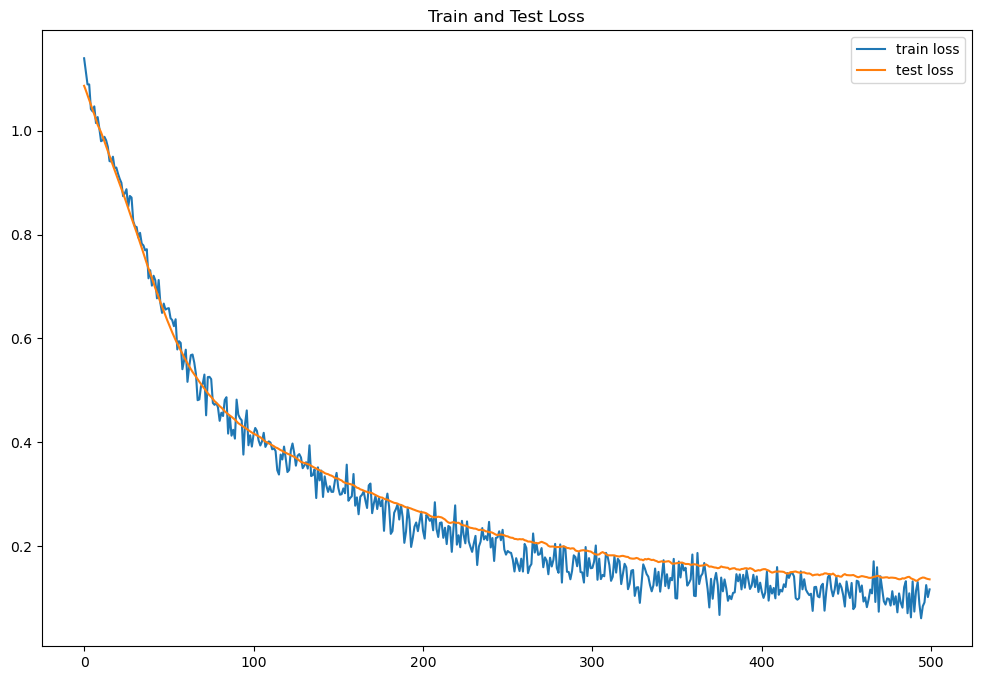

In [9]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title("Train and Test Loss")
plt.legend()
plt.show()

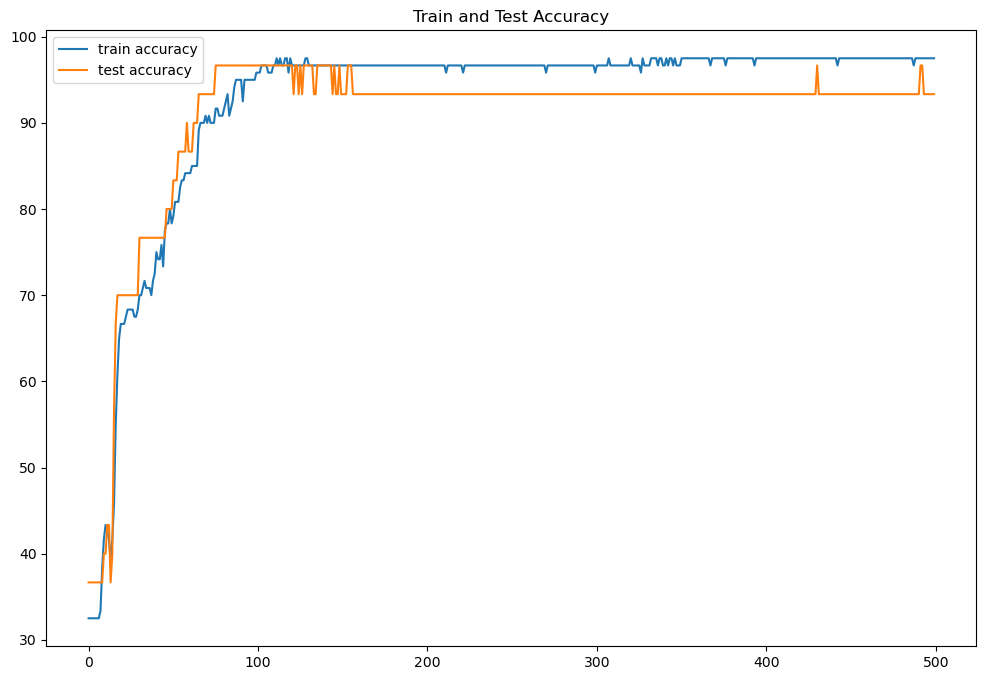

In [10]:
train_accuracy_cpu = [item.cpu() for item in train_accuracy]
test_accuracy_cpu = [item.cpu() for item in test_accuracy]
fig = plt.figure(figsize=(12, 8))
plt.plot(train_accuracy_cpu, label='train accuracy')
plt.plot(test_accuracy_cpu, label='test accuracy')
plt.title("Train and Test Accuracy")
plt.legend()
plt.show()

### Saving the model to disk, and loading it back

In [11]:
torch.save(net.state_dict(), "./2.model.pth")

In [12]:
net2 = IrisNet(4, 100, 50, 3)
net2.load_state_dict(torch.load("./2.model.pth"))

<All keys matched successfully>

In [13]:
output = net2(Variable(torch.FloatTensor([[5.1, 3.5, 1.4, 0.2]])))

In [14]:
_, predicted_class = torch.max(output.data, 1)
print('Predicted class: ', predicted_class.numpy()[0])
print('Expected class: ', 0 )

Predicted class:  0
Expected class:  0
